In [1]:
import gensim
import os
import collections
import smart_open
import random
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
ls -lh ../paraphrases/

total 9,9M
-rw-r--r-- 1 fogside fogside 4,8M ноя 28  2015 corpus.xml
-rw-r--r-- 1 fogside fogside 1,2K апр 16  2015 LICENSE
-rw-r--r-- 1 fogside fogside 1,6M ноя 24 11:28 paraphrases.csv
-rw-r--r-- 1 fogside fogside 3,6M ноя 28  2015 paraphrases.xml


### The table below summarizes the dataset 

|Dataset|Type|Inventory|Corpus|Split|Num. of words|Num. of senses|Avg. num. of senses|Num. of contexts|
|-----|-----|---------|-----|------|:---------:|:----------:|:----------:|:----------:|
|wiki-wiki|main|Wikipedia|Wikipedia|train|4|8|2.0|439
|bts-rnc|main|Gramota.ru|RNC|train|30|96|3.2|3491
|active-dict|main|Active Dict.|Active Dict.|train|85|312|3.7|2073
|active-rnc|additional|Active Dict.|RNC|train|20|71|3.6|1829
|active-rutenten|additional|Active Dict.|ruTenTen|train|21|71|3.4|3671
|bts-rutenten|additional|Gramota.ru|ruTenTen|train|11|25|2.3|956

# Paraphrases:
Paraphrase classes: -1: non-paraphrases, 0: loose paraphrases, 1: strict paraphrases

In [4]:
import xml.etree.ElementTree as ET
data=[]
parser = ET.XMLParser(encoding="utf-8")
tree = ET.parse('../paraphrases/paraphrases.xml', parser=parser)
for elem in tree.iter(tag='value'):
    if elem.attrib['name'] == 'id':
        data.append({'id':elem.text})
    if elem.attrib['name'] == 'text_1':
        data[-1]['text_1'] = elem.text
        
    if elem.attrib['name'] == 'text_2':
        data[-1]['text_2'] = elem.text
        
    if elem.attrib['name'] == 'class':
        data[-1]['class'] = elem.text
        
    if elem.attrib['name'] == 'jaccard':
        data[-1]['jaccard'] = elem.text

In [5]:
len(data)

7227

In [7]:
df = pd.DataFrame(data=data)
df.to_csv("../paraphrases/paraphrases.csv", index=False)
df.head()

,class,id,jaccard,text_1,text_2
0,0,1,0.65,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...
1,0,2,0.5,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...
2,0,3,0.611429,Президент Египта ввел чрезвычайное положение в...,Власти Египта угрожают ввести в стране чрезвыч...
3,-1,4,0.324037,Вернувшихся из Сирии россиян волнует вопрос тр...,Самолеты МЧС вывезут россиян из разрушенной Си...
4,0,5,0.606218,В Москву из Сирии вернулись 2 самолета МЧС с р...,Самолеты МЧС вывезут россиян из разрушенной Си...


In [8]:
df.columns

Index(['class', 'id', 'jaccard', 'text_1', 'text_2'], dtype='object')

In [9]:
# from pymystem3 import Mystem
# import re

# mystem = Mystem()

def lemmatize(sent,i=None):
    if i is not None:
        return gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(sent), [i])
    else:
        gensim.utils.simple_preprocess(sent)
#      [w.lower() for w in mystem.lemmatize(sent) if re.match('[\w\-]+$', w)]

## Make train corpus from paraphrases

In [10]:
train_corpus = []

for i, item in df.iterrows():
    if (int(item['class']) >= 0):
        train_corpus.append(lemmatize(item.text_1, i))
        train_corpus.append(lemmatize(item.text_2, i))

len(train_corpus)

9290

In [11]:
train_corpus[0]

TaggedDocument(words=['полицейским', 'разрешат', 'стрелять', 'на', 'поражение', 'по', 'гражданам', 'травматикой'], tags=[0])

## Make train corpus from additional data
**Sanity check**

проверим, возможно ли вообще переобучится, зная золотую разметку

In [189]:
from testing_interface import make_data

In [190]:
contexts, main_words, labels, word_list_uniq = make_data(df_file_name='../data/main/bts-rnc/train.csv',\
                 use_gensim_simple_preproc=True,\
                 throw_main_word=True, tokenize=False)

In [194]:
train_corpus = []

for i, word, sent in zip(labels, main_words, contexts):
    label = word+i.split('.')[0]
    train_corpus.append(lemmatize(sent, label))

len(train_corpus)

3491

# Doc2Vec

In [195]:
model = gensim.models.doc2vec.Doc2Vec(size=50, min_count=2, iter=100)

In [196]:
model.build_vocab(train_corpus)

In [197]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)

CPU times: user 11.4 s, sys: 819 ms, total: 12.2 s
Wall time: 7.09 s


4885600

In [198]:
model.infer_vector(['квантовая', 'любовь', 'далека', 'от', 'теории', 'поля'])

array([-0.17808102,  0.11023267, -0.09815314,  0.03743504, -0.14032637,
       -0.00923229, -0.01952063,  0.12108386,  0.12969495, -0.07498223,
        0.03708415,  0.0448918 , -0.05753965,  0.03855833,  0.06078742,
       -0.05369772, -0.05765378, -0.07466155,  0.1326744 ,  0.01188599,
       -0.02431175,  0.14000112,  0.11106348, -0.02659046,  0.00610367,
       -0.02400974,  0.03812255, -0.06382255, -0.00239041,  0.07534651,
       -0.00616704, -0.04976986, -0.18651815,  0.00657196, -0.03900024,
       -0.10987577, -0.0215564 , -0.10050777, -0.0660895 , -0.08227695,
       -0.08077476, -0.08243375, -0.02843815, -0.00371148,  0.06351481,
       -0.00748474,  0.06443185, -0.00119789,  0.00350638,  0.09667807], dtype=float32)

In [199]:
from typing import List

def make_features(model, docs:List[List[str]])->List[List[float]]:
    return [model.infer_vector(s) for s in docs]

# Маленький тест

In [200]:
from sklearn.metrics.pairwise import cosine_similarity

In [201]:
s1 = 'Отвергнуть щедрый дар'
s2 = 'покупать преданность дарами и наградами'
s3 = 'У нее с детства был дар передразнивать знакомых'
s4 = 'Считалось, что Андрей Иванович обладает необыкновенным даром «выведывать мысли»'
s5 = 'Мы начнем с теории поля и дойдем до квантовой механики.'
tags = [1, 1, 2, 2, 3]
sents_raw = [s1,s2,s3,s4,s5]

In [202]:
sents = [gensim.utils.simple_preprocess(sent) for sent in sents_raw]
sents

[['отвергнуть', 'щедрый', 'дар'],
 ['покупать', 'преданность', 'дарами', 'наградами'],
 ['нее', 'детства', 'был', 'дар', 'передразнивать', 'знакомых'],
 ['считалось',
  'что',
  'андрей',
  'иванович',
  'обладает',
  'необыкновенным',
  'даром',
  'выведывать',
  'мысли'],
 ['мы', 'начнем', 'теории', 'поля', 'дойдем', 'до', 'квантовой', 'механики']]

In [293]:
vecs = [model.infer_vector(s) for s in sents]
sim_mtx = cosine_similarity(vecs,vecs)
sim_mtx

array([[ 1.00000012, -0.13120861, -0.15742621, -0.35480472,  0.04529612],
       [-0.13120861,  1.        ,  0.12918913,  0.13837336,  0.18975195],
       [-0.15742621,  0.12918913,  1.        ,  0.21029139,  0.09466392],
       [-0.35480472,  0.13837336,  0.21029139,  1.00000012,  0.22233504],
       [ 0.04529612,  0.18975195,  0.09466392,  0.22233504,  1.00000012]], dtype=float32)

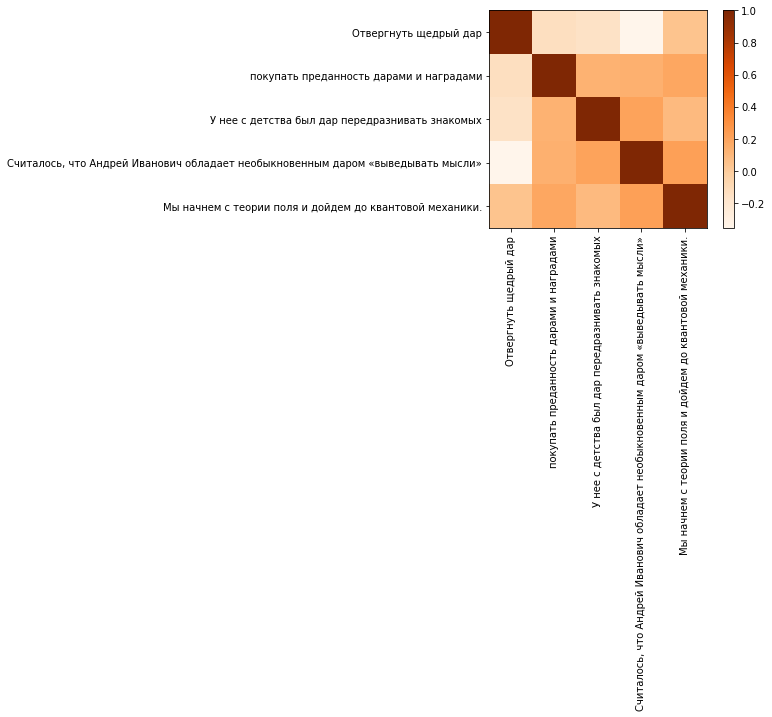

In [294]:
plt.xticks(range(5), sents_raw, rotation=90)
plt.yticks(range(len(sents_raw)), sents_raw, rotation=0)

plt.imshow(sim_mtx, cmap='Oranges')
plt.colorbar()
plt.show()

Близкие векторы между предложениями из 2 и 1 тегов. А именно:
* 'покупать преданность дарами и наградами'
* 'У нее с детства был дар передразнивать знакомых'

Что будет, если убрать слово ключевое отовсюду?

In [211]:
import re
sents2 = [[w for w in s if not re.match('^дар', w)] for s in sents]

In [215]:
sents2

[['отвергнуть', 'щедрый'],
 ['покупать', 'преданность', 'наградами'],
 ['нее', 'детства', 'был', 'передразнивать', 'знакомых'],
 ['считалось',
  'что',
  'андрей',
  'иванович',
  'обладает',
  'необыкновенным',
  'выведывать',
  'мысли'],
 ['мы', 'начнем', 'теории', 'поля', 'дойдем', 'до', 'квантовой', 'механики']]

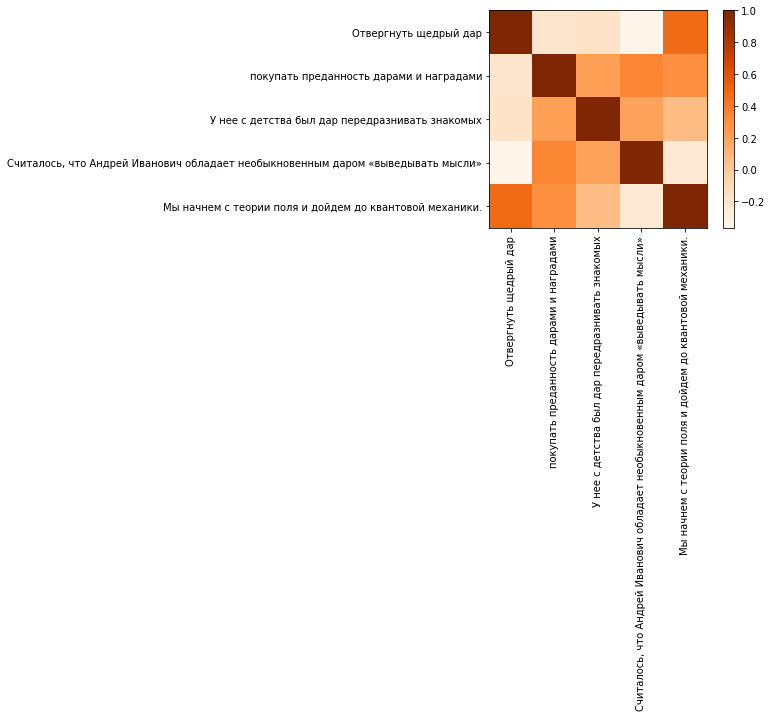

In [301]:
vecs = [model.infer_vector(s) for s in sents2]
sim_mtx = cosine_similarity(vecs,vecs)

plt.xticks(range(5), sents_raw, rotation=90)
plt.yticks(range(5), sents_raw, rotation=0)

plt.imshow(sim_mtx, cmap='Oranges')
plt.colorbar()
plt.show()

Кажется, что ситуация немного поменялась, но сильно лучше не стала.

# Проверим метрики и алгоритмы кластеризации

In [178]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
%autoreload 2

In [414]:
from testing_interface import make_data,\
                              visualize_pca,\
                              evaluate_weighted_ari,\
                              get_one_word_data,\
                              visualize_pca_one_word,\
                              visualize_tsne_one_word

DATASET = '../data/additional/bts-rutenten/train.csv'

In [415]:
contexts, main_words, labels, word_list_uniq = make_data(df_file_name=DATASET,\
                 use_gensim_simple_preproc=True,\
                 throw_main_word=True, tokenize=True)

In [416]:
print(word_list_uniq)

['дисциплина' 'замок' 'корона' 'кран' 'лавка' 'летопись' 'мат' 'отклонение'
 'сук' 'тост' 'щель']


In [417]:
features = make_features(model, contexts)

In [418]:
# visualize_pca_one_word(features, main_words=main_words, labels=labels, word='бор')

In [419]:
# visualize_tsne_one_word(features, main_words=main_words, labels=labels, word='бор')

Кажется, что даже в исходной "золотой разметке" при текущих эмбеддингах не выделяется никаких красивых кластеров.

In [420]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, random_state=42)

In [421]:
pred_labels = []
for word in word_list_uniq:
    feats, gold_labels = get_one_word_data(features, main_words=main_words, labels=labels, word=word)
    p_labels = km.fit_predict(feats)
    pred_labels.extend(p_labels)

In [422]:
evaluate_weighted_ari(DATASET, pred_labels)

word	ari	count
дисциплина	0.058079	98
замок	-0.012222	91
корона	-0.013069	78
кран	0.052804	94
лавка	-0.053170	90
летопись	0.033322	95
мат	-0.036286	67
отклонение	-0.035960	94
сук	0.000000	64
тост	-0.032188	91
щель	-0.015407	94
	-0.003436	956


In [423]:
!python3 ../evaluate.py ../data/additional/bts-rutenten/train.baseline-adagram.csv

word	ari	count
дисциплина	0.479289	98
замок	0.390790	91
корона	0.148973	78
кран	0.204803	94
лавка	0.303380	90
летопись	0.113282	95
мат	0.115854	67
отклонение	0.291074	94
сук	0.000000	64
тост	0.520631	91
щель	-0.017116	94
	0.243056	956
